In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import defaultdict

Load the dataset from csv file and print first 5 rows to verify that the dataset has been loaded correctly

csv file contains image paths, scan parameters (CTDI, kV, mA) and the target value D.

In [ ]:
csv_path = '/content/drive/MyDrive/zavrsni rad/dataset/dataset.csv'
data = pd.read_csv(csv_path)
print(data.head())

                                          image_path  Series  CTDI   kV   mA  \
0  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
1  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
2  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
3  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   
4  /content/drive/MyDrive/zavrsni rad/dataset/dat...      10   4.9  100  153   

   size  
0   7.5  
1   7.5  
2   7.5  
3   7.5  
4   7.5  


Split dataset into training - 70% and testing - 30%

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

- all images resized to 224x224 pixels to match ResNet input requirements

- imagesconverted to PyTorch tensors

- images normalized using ImageNet mean and standard deviation values for each color channel


In [ ]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

Dataset class to load images, scan parameters, and target values.

This dataset loads CT images along with their scan settings and target values.

For each row, it loads the image from the specified path and applies the given transformations.

The scan parameters (CTDI, kV, mA) are converted into tensors for use in the model.

In [ ]:
class AppendixDataset(Dataset):
    def __init__(self, csv_file=None, dataframe=None, transform=None):
        import pandas as pd
        if dataframe is not None:
            self.data = dataframe
        elif csv_file is not None:
            self.data = pd.read_csv(csv_file)
        else:
            raise Exception("CSV path or dataframe required!")
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        image = Image.open(row['image_path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        params = torch.tensor([row['CTDI'],row['kV'],row['mA']], dtype=torch.float32)
        label = torch.tensor(row['size'], dtype=torch.float32)
        series = row['Series']

        return image, params, label, series


Create a DataLoader for efficient batch loading.

Initialize the dataset with image transformations, then load data in batches of 16. The data is shuffled every epoch to enhance training performance, and 4 worker processes are used to speed up data loading.

In [ ]:
train_dataset = AppendixDataset(dataframe=train_data, transform=image_transforms)
test_dataset = AppendixDataset(dataframe=test_data, transform=image_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Load pretrained ResNet18 and remove final classification layer

Since the task is regression, the final classification layer is replaced with an identity layer. This makes the model output a 512-dimensional feature vector instead of class probabilities, which can be combined with other inputs like scan parameters.

In [ ]:
resnet = models.resnet18(pretrained=True)

resnet.fc = nn.Identity()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 137MB/s]


MLP for processing scan parameters: 3 inputs (CTDI, kV, mA), with 2 linear layers + ReLU. Outputs a 16-dimensional feature vector to combine with image features.

In [ ]:
class ParamsMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
    def forward(self, x):
        return self.layers(x)

param_mlp = ParamsMLP()

Model that combines features from CT images and scan parameters to predict appendix size.

In [ ]:
class AppendixSizeModel(nn.Module):
    def __init__(self, CTscan_model, param_model):
        super().__init__()
        self.cnn = CTscan_model
        self.param_mlp = param_model
        self.fc = nn.Sequential(
            nn.Linear(512 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, image, params):
        img_feat = self.cnn(image)                              #get features from image using cnn
        param_feat = self.param_mlp(params)                     #get features from scan parameters using MLP
        combined = torch.cat((img_feat, param_feat), dim=1)     #combine image and parameter features
        output = self.fc(combined)                              #predict appendix size
        return output.squeeze(1)

Initialize model with ResNet and MLP.

Use MSE loss and Adam optimizer (lr=0.0001).  

In [ ]:
model = AppendixSizeModel(resnet, param_mlp)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

model.train()

AppendixSizeModel(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Training loop that processes batches of data, computes predictions and loss, updates model weights, and prints loss each step.

In [ ]:
num_epochs = 10
train_losses_per_epoch = []
train_series_losses = defaultdict(list)

for epoch in range(num_epochs):
    train_losses = []

    for images, params, labels, series in train_loader:
        optimizer.zero_grad()
        outputs = model(images, params)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        print(f"Train Loss: {loss.item():.4f}")
        abs_error = torch.abs(outputs - labels)
        for err_val, series_name in zip(abs_error.detach().cpu().numpy(), series):
          train_series_losses[series_name].append(err_val)

    avg_train_loss = sum(train_losses) / len(train_losses)
    train_losses_per_epoch.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}")


Train Loss: 72.0842
Train Loss: 69.0339
Train Loss: 63.7318
Train Loss: 59.6191
Train Loss: 55.0496
Train Loss: 52.1869
Train Loss: 48.0870
Train Loss: 44.9511
Train Loss: 41.4822
Train Loss: 38.8846
Train Loss: 36.8712
Train Loss: 33.8881
Train Loss: 30.4864
Train Loss: 29.2161
Train Loss: 24.9511
Train Loss: 22.4704
Epoch [1/10], Average Train Loss: 45.1871
Train Loss: 19.4033
Train Loss: 17.8982
Train Loss: 18.0007
Train Loss: 15.7156
Train Loss: 17.4176
Train Loss: 14.1181
Train Loss: 13.0906
Train Loss: 9.6581
Train Loss: 8.2971
Train Loss: 10.1507
Train Loss: 8.4179
Train Loss: 7.3623
Train Loss: 5.4863
Train Loss: 4.0781
Train Loss: 5.1794
Train Loss: 3.1448
Epoch [2/10], Average Train Loss: 11.0887
Train Loss: 2.6805
Train Loss: 3.5810
Train Loss: 5.4974
Train Loss: 1.1434
Train Loss: 1.7688
Train Loss: 0.8389
Train Loss: 0.6702
Train Loss: 1.7968
Train Loss: 2.2376
Train Loss: 0.4238
Train Loss: 0.3068
Train Loss: 0.1568
Train Loss: 0.1163
Train Loss: 0.5983
Train Loss: 0.3483

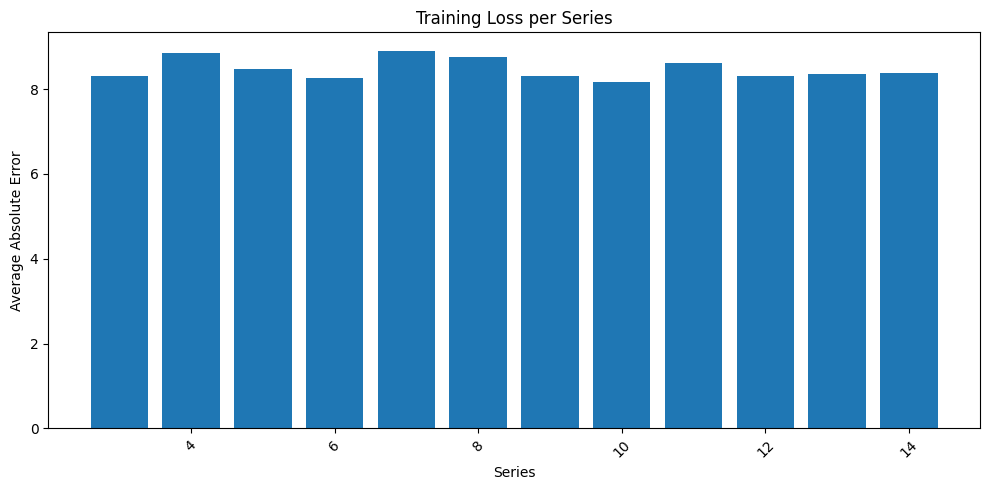

In [ ]:
import matplotlib.pyplot as plt

#calculate average absolute loss per series
avg_train_loss_per_series = {
    s: sum(vals)/len(vals) for s, vals in train_series_losses.items()
}

#plot
plt.figure(figsize=(10, 5))
plt.bar(avg_train_loss_per_series.keys(), avg_train_loss_per_series.values())
plt.xlabel('Series')
plt.ylabel('Average Absolute Error')
plt.title('Training Loss per Series')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


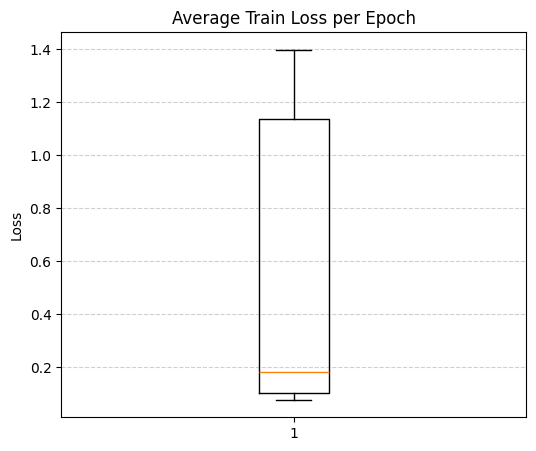

In [ ]:
plt.figure(figsize=(6, 5))
plt.boxplot(train_losses_per_epoch, showfliers=False)
plt.title('Average Train Loss per Epoch')
plt.ylabel('Loss')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


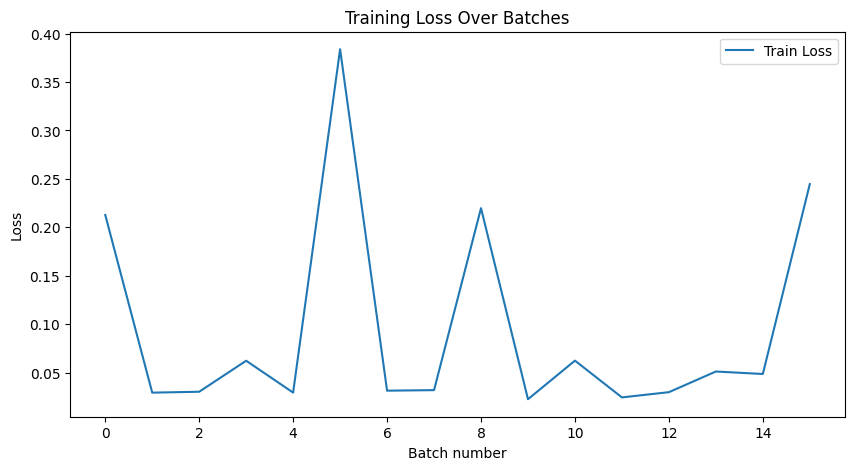

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Training Loss Over Batches')
plt.legend()
plt.show()

In [ ]:
model.eval()

test_losses = []
total_loss = 0
count = 0
test_series_losses = defaultdict(list)

with torch.no_grad():
    for images, params, labels, series in test_loader:
        outputs = model(images, params)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())

        total_loss += loss.item() * images.size(0)
        count += images.size(0)

        print(f"Test Loss: {loss.item():.4f}")
        abs_error = torch.abs(outputs - labels)
        for error_value, series_name in zip(abs_error.cpu().numpy(), series):
          series_key = str(series_name.item())
          test_series_losses[series_key].append(error_value)


avg_test_loss = total_loss / count
print(f"Average Test Loss: {avg_test_loss:.4f}")
print("-" * 50)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Loss: 0.0251
Test Loss: 0.0503
Test Loss: 0.0151
Test Loss: 0.0418
Test Loss: 0.0093
Test Loss: 0.0144
Test Loss: 0.0239
Average Test Loss: 0.0258
--------------------------------------------------


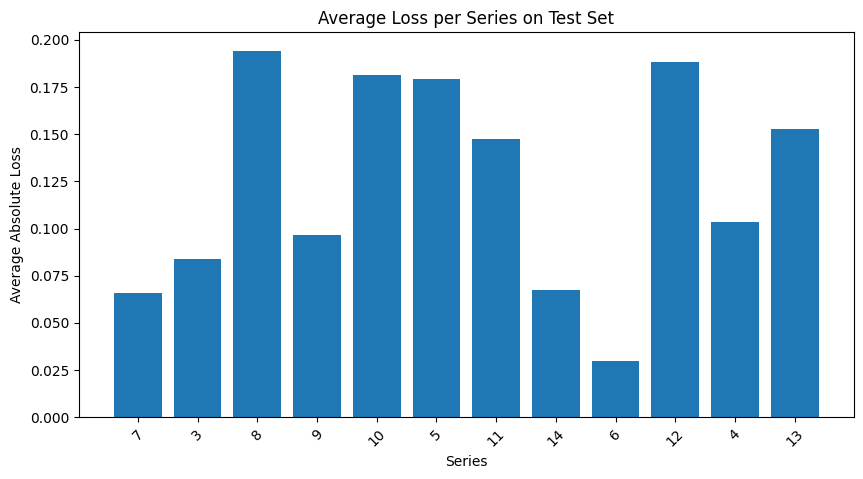

In [ ]:
#average loss per series
avg_loss_per_series = {series: sum(errors)/len(errors) for series, errors in test_series_losses.items()}

series_names = list(avg_loss_per_series.keys())
avg_losses = [avg_loss_per_series[s] for s in series_names]

plt.figure(figsize=(10,5))
plt.bar(series_names, avg_losses)
plt.xlabel('Series')
plt.ylabel('Average Absolute Loss')
plt.title('Average Loss per Series on Test Set')
plt.xticks(rotation=45)
plt.show()

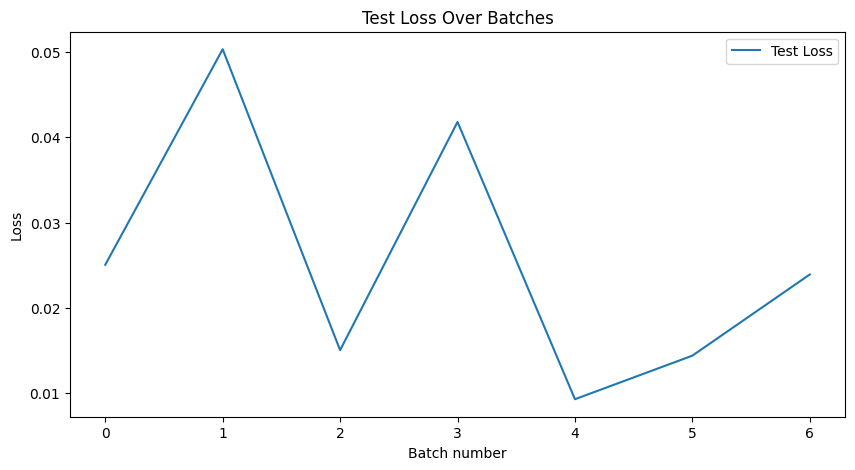

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.title('Test Loss Over Batches')
plt.legend()
plt.show()

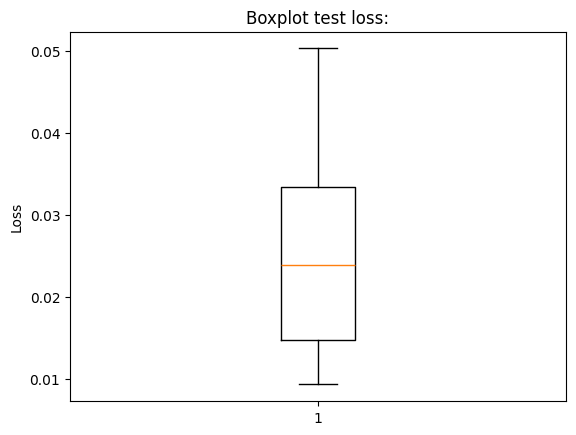

In [ ]:
import matplotlib.pyplot as plt

plt.boxplot(test_losses)
plt.title('Boxplot test loss:')
plt.ylabel('Loss')
plt.show()


Train 70%, test 30%

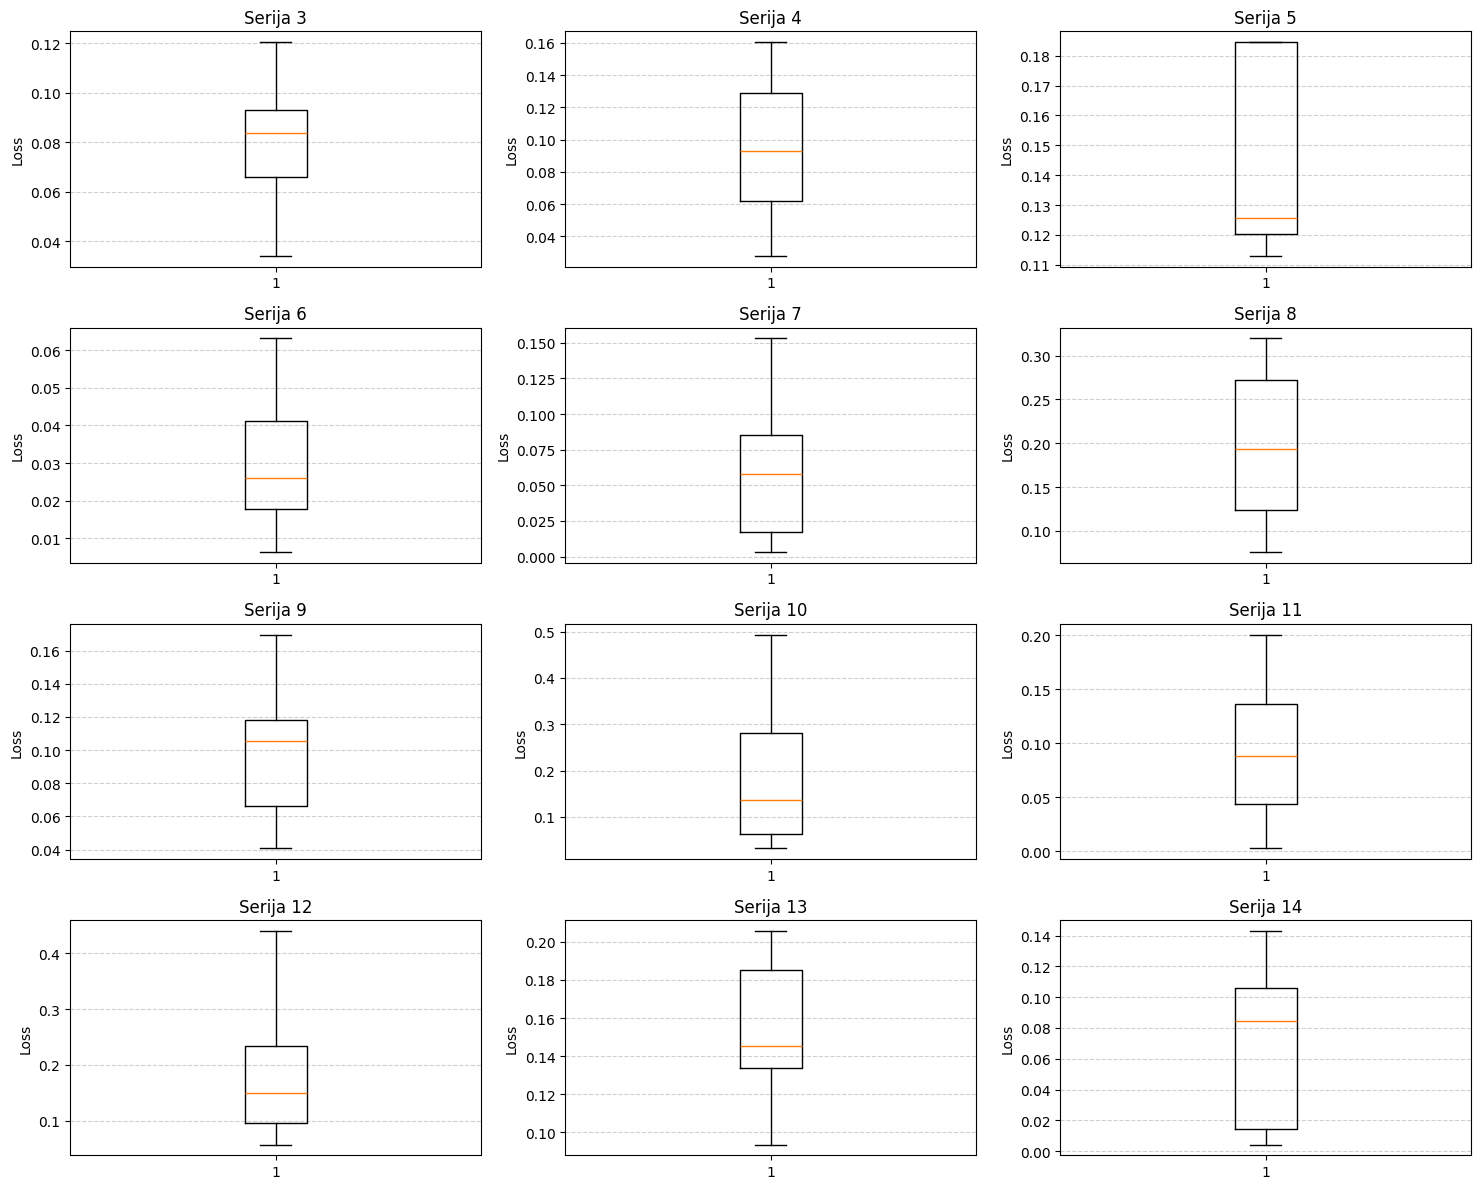

In [ ]:
import matplotlib.pyplot as plt

series_keys = sorted(test_series_losses.keys(), key=int)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for idx, series_name in enumerate(series_keys):
    errors = test_series_losses[series_name]
    axes[idx].boxplot(errors, showfliers=False)
    axes[idx].set_title(f'Serija {series_name}')
    axes[idx].set_ylabel('Loss')
    axes[idx].grid(axis='y', linestyle='--', alpha=0.6)

for i in range(len(series_keys), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [ ]:
print(test_series_losses)

defaultdict(<class 'list'>, {'7': [np.float32(0.05780077), np.float32(0.09672928), np.float32(0.0070667267), np.float32(0.15320587), np.float32(0.039206505), np.float32(0.07444191), np.float32(0.010406494), np.float32(0.003165722), np.float32(0.19694757), np.float32(0.06215), np.float32(0.024802685)], '3': [np.float32(0.08471823), np.float32(0.12043047), np.float32(0.07803154), np.float32(0.0467124), np.float32(0.08374739), np.float32(0.14577723), np.float32(0.093015194), np.float32(0.06591368), np.float32(0.034213066)], '8': [np.float32(0.2837081), np.float32(0.075911045), np.float32(0.18769693), np.float32(0.31971455), np.float32(0.26783276), np.float32(0.19886923), np.float32(0.13803387), np.float32(0.08272171)], '9': [np.float32(0.1696639), np.float32(0.14328623), np.float32(0.04628992), np.float32(0.105546), np.float32(0.1077714), np.float32(0.0664773), np.float32(0.07264805), np.float32(0.11836815), np.float32(0.040745735)], '10': [np.float32(0.15343094), np.float32(0.03188324), 